In [1]:
from allensdk.api.queries.biophysical_api import BiophysicalApi

neuronal_model_id =  485591806    # get this from the web site
model_directory = './source/'    # the files will be downloaded to the 'source' folder under current directory

bp = BiophysicalApi('http://api.brain-map.org')
bp.cache_stimulus = False # don't want to download the large stimulus NWB file
bp.cache_data(neuronal_model_id, working_directory=model_directory)

2020-04-30 23:39:10,895 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/492101095
2020-04-30 23:39:11,252 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/496605151
2020-04-30 23:39:11,409 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2020-04-30 23:39:11,521 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337054
2020-04-30 23:39:11,623 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337225
2020-04-30 23:39:11,725 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337019
2020-04-30 23:39:11,833 allensdk.api.api.retrieve_fi

In [2]:
from allensdk.api.queries.cell_types_api import CellTypesApi
cta = CellTypesApi() # the CellTypesApi instance
cell = cta.get_cell(4845590000)
cell

In [3]:
from allensdk.api.queries.rma_api import RmaApi
rma = RmaApi() # the RmaApi instance
data = rma.model_query(model='EphysFeature',criteria='[specimen_id$eq484559000]')[0]
data

{'adaptation': 0.0081539780749065,
 'avg_isi': 78.9129166666667,
 'electrode_0_pa': 21.9081246199959,
 'f_i_curve_slope': 0.148720608859549,
 'fast_trough_t_long_square': 1.109125,
 'fast_trough_t_ramp': 4.86082833333333,
 'fast_trough_t_short_square': 1.024905,
 'fast_trough_v_long_square': -45.9062538146973,
 'fast_trough_v_ramp': -49.7500025431315,
 'fast_trough_v_short_square': -53.3062522888184,
 'has_burst': False,
 'has_delay': False,
 'has_pause': False,
 'id': 484579736,
 'input_resistance_mohm': 113.40336,
 'latency': 0.0446200000000001,
 'peak_t_long_square': 1.107065,
 'peak_t_ramp': 4.85904666666667,
 'peak_t_short_square': 1.023385,
 'peak_v_long_square': 29.5000019073486,
 'peak_v_ramp': 31.9687506357829,
 'peak_v_short_square': 32.2625011444092,
 'rheobase_sweep_id': 484564045,
 'rheobase_sweep_number': 42,
 'ri': 118.43753606081,
 'sag': 0.103550091385841,
 'seal_gohm': 2.254352896,
 'slow_trough_t_long_square': 1.13875,
 'slow_trough_t_ramp': 4.896285,
 'slow_trough_t

In [4]:
# based on allensdk.model.biophysical.biophysical_perisomatic.runner

# These will be useful for accessing and configuring the downloaded model
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

# not using NwbDataSet
# from allensdk.core.nwb_data_set import NwbDataSet

# We'll save results to a simple text file instead
from allensdk.core.dat_utilities import DatUtilities

import os
cwd = os.getcwd()

In [5]:
os.chdir('source')
print(os.system('nrnivmodl modfiles')) # compile modfiles. Return 0 for success, 1 for failure.
os.chdir(cwd)

0


In [6]:
os.chdir('source')

description = Config().load('manifest.json')
utils = Utils(description)
h = utils.h # NEURON handle

# configure model
manifest = description.manifest
morphology_path = description.manifest.get_path('MORPHOLOGY')
utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
utils.load_cell_parameters()

os.chdir(cwd)

In [7]:
stim = h.IClamp(h.soma[0](0.5))
stim.amp = 0.12  # nA
stim.delay = 500.0
stim.dur = 1000.0

h.tstop = 2000.0

vec = utils.record_values()

In [8]:
h.finitialize()
h.run()

0.0

In [9]:
import numpy

output_path = './source/output_voltage.dat'

junction_potential = description.data['fitting'][0]['junction_potential']
mV = 1.0e-3
ms = 1.0e-3

output_data = (numpy.array(vec['v']) - junction_potential) * mV
output_times = numpy.array(vec['t']) * ms

data = numpy.transpose(numpy.vstack((output_times, output_data)))
with open (output_path, "w") as f:
    numpy.savetxt(f, data)

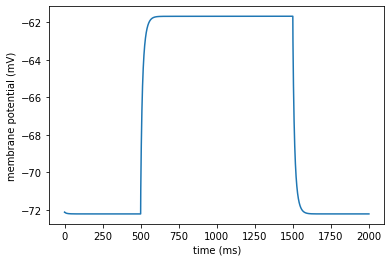

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(vec['t'], numpy.array(vec['v']) - junction_potential)
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)')
plt.show()